In [1]:
import importlib

import settings
import VPINN_tri_final
import mesh_lib

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights
import os 

importlib.reload(settings)
importlib.reload(mesh_lib)
importlib.reload(VPINN_tri_final)

from settings import *
from mesh_lib import *
from VPINN_tri_final import *
#tf.config.run_functions_eagerly(True)


os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2023-11-18 02:50:21.450012: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 02:50:21.451334: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 02:50:21.483007: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 02:50:21.483718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 02:50:22.041453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

settings_lib imported 
interpolator_lib imported
mesh_lib imported
settings_lib imported 
mesh_lib imported


degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


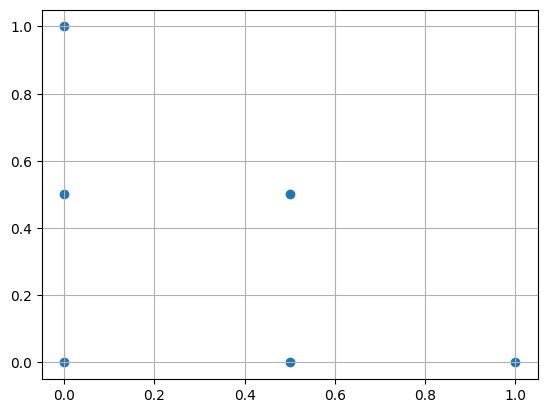

In [2]:
basis=interpolator(2,False,False,points=None)

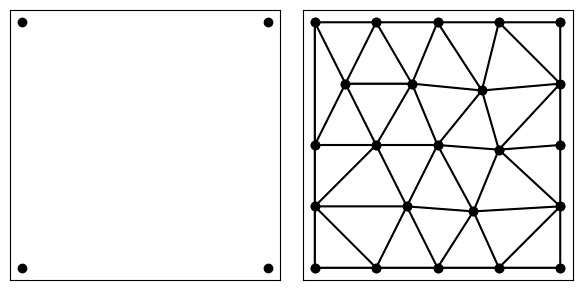

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr

# Step 1: Generate a fine mesh
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A, 'qnea0.05')
tr.compare(plt,A,B)

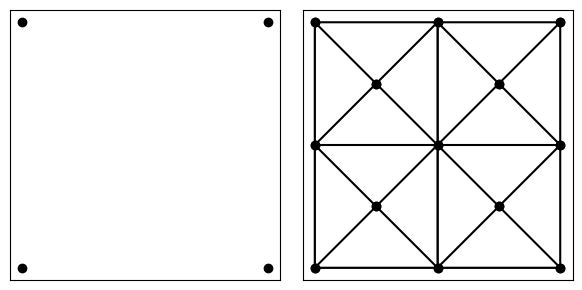

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr



# Step 1: Generate a fine mesh
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A,'qnea0.1')

tr.compare(plt, A, B)

[[ 4 12]
 [ 9 12]
 [ 4  9]
 [ 4  8]
 [ 4  5]
 [ 5  8]
 [ 7 10]
 [ 3  7]
 [ 3 10]
 [ 3  5]
 [ 5 10]
 [ 4  6]
 [ 6 12]
 [ 6  8]
 [ 0  6]
 [ 0  8]
 [ 2 11]
 [ 2  7]
 [ 7 11]
 [ 0  5]
 [ 2  9]
 [ 9 11]
 [ 4  7]
 [ 4 10]
 [ 4 11]
 [ 1  9]
 [ 1 12]
 [ 1  6]]


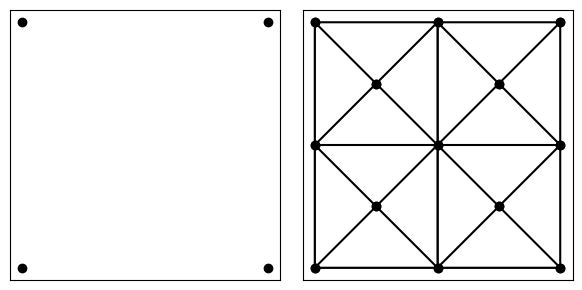

In [5]:

#edges flipping 

for i in range(len(B['edges'])):
    ii=B['edges'][i][0]
    jj=B['edges'][i][1]

    if ii>jj:
            B['edges'][i][0],B['edges'][i][1]=B['edges'][i][1],B['edges'][i][0]

tr.compare(plt, A, B)

print(B['edges'])

In [6]:

#util functions

def get_triangle_edges(triangle_vertices,edges):
    triangle_edges = []
 

    keep=np.zeros((3,),dtype=np.int64)

    for i in range(3):
        ii=triangle_vertices[i].copy()
        jj=triangle_vertices[(i + 1) % 3].copy()
        

        if(ii>jj):
            edge=np.array([jj,ii])
        else:
            edge=np.array([ii,jj])

        index= np.where(np.all(edges == edge, axis=1))[0][0]
        
        triangle_edges.append(index)

        if ii>jj:
            keep[i]=1

    triangle_edges=np.array(triangle_edges)
        
    return keep,triangle_edges

In [7]:
#flipping part + edges
l=[]
temp=[]
for triangle in B['triangles']:
    keep,t=get_triangle_edges(triangle,B['edges'])
    l.append(keep)
    temp.append(t)



keep=np.asarray(l)
edges_index_inside_triangle=np.asarray(temp)

In [8]:
B['keep']=keep
B['edges_index_inside_triangle']=edges_index_inside_triangle

In [9]:
B.keys()

dict_keys(['vertices', 'vertex_markers', 'triangles', 'neighbors', 'edges', 'edge_markers', 'keep', 'edges_index_inside_triangle'])

In [10]:
#exp
n_vertices=len(B['vertices'])
n_traingles=len(B['triangles'])
n_edges=len(B['edges'])

n_inside_edge=basis.n_inside_edge
n_inside=basis.n_inside

vertices_contribution=np.zeros((n_vertices,1))
edges_contribution=np.zeros((n_edges,n_inside_edge))
inside_contribution=np.zeros((n_traingles,n_inside))




for index,triangle in enumerate(B['triangles']):


    if (B['vertex_markers'][triangle[0]]==0):
            vertices_contribution[triangle[0]]=1
    else:
          vertices_contribution[triangle[0]]=2

    if (B['vertex_markers'][triangle[1]]==0):
            vertices_contribution[triangle[1]]=1
    else:
          vertices_contribution[triangle[1]]=2    

    if (B['vertex_markers'][triangle[2]]==0):
            vertices_contribution[triangle[2]]=1
    else:
          vertices_contribution[triangle[2]]=2
    

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][0]]==0):
           
           edges_contribution[B['edges_index_inside_triangle'][index][0]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][1]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][1]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][2]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][2]]+=3      



print(B['edges'])
print(edges_contribution)


    
                                   

[[ 4 12]
 [ 9 12]
 [ 4  9]
 [ 4  8]
 [ 4  5]
 [ 5  8]
 [ 7 10]
 [ 3  7]
 [ 3 10]
 [ 3  5]
 [ 5 10]
 [ 4  6]
 [ 6 12]
 [ 6  8]
 [ 0  6]
 [ 0  8]
 [ 2 11]
 [ 2  7]
 [ 7 11]
 [ 0  5]
 [ 2  9]
 [ 9 11]
 [ 4  7]
 [ 4 10]
 [ 4 11]
 [ 1  9]
 [ 1 12]
 [ 1  6]]
[[6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]
 [0.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]]


In [11]:
tfk=tf.keras
tfkl=tf.keras.layers

In [12]:
model = tfk.models.Sequential()
model.add(tf.keras.Input(shape=(2,),dtype=tf.float64))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer="glorot_uniform",dtype=tf.float64))

In [13]:
print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371 (2.90 KB)
Trainable params: 371 (2.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
(None, 2)
(None, 1)


In [14]:
print()

In [15]:
print(model.trainable_variables)

[<tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float64, numpy=
array([[-0.68190247, -0.36809422,  0.25980899, -0.66082344, -0.66647458,
         0.05405067,  0.10895519,  0.04700928, -0.17387805,  0.41975432],
       [-0.33729535, -0.54867216, -0.09310245, -0.43788865, -0.63537053,
        -0.11379857, -0.36396182, -0.36175282, -0.22168651,  0.65336653]])>, <tf.Variable 'dense/bias:0' shape=(10,) dtype=float64, numpy=
array([ 0.19943484,  0.20537549,  0.35174151, -0.11907396,  0.13777394,
       -0.12212489, -0.49614729,  0.21049361,  0.35861866,  0.39855158])>, <tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float64, numpy=
array([[ 0.46208138,  0.00208709, -0.26865386,  0.25318169, -0.05774983,
         0.08434161, -0.07908006, -0.38252605,  0.38657671, -0.3777857 ],
       [ 0.10562851,  0.02041168, -0.27120028,  0.18466245, -0.18982874,
        -0.18570565, -0.13708224,  0.51056561, -0.39110738,  0.54103944],
       [ 0.2545942 ,  0.1280718 , -0.06844669,  0.26391425, -0.1

In [16]:
from settings import *
N_tests = 2
N_elements = [5, 5]
params = {'scheme': 'VPINNs',
            'NN_struct': [2] + [5] * 3 + [1],
            'var_form': 1,
            'n_elements': tuple(N_elements),
            'n_test': [N_elements[0]*[N_tests], N_elements[1]*[N_tests]],
            'n_quad': 50,
            'n_bound': 80, # for every edge 
            'n_residual': 100,
            'domain': ((0.0, 1.0), (0.0, 1.0)),
            'Opt_Niter': 15000 + 1,
            'delta_test': 0.01,
            'N_test':N_tests}

25
degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


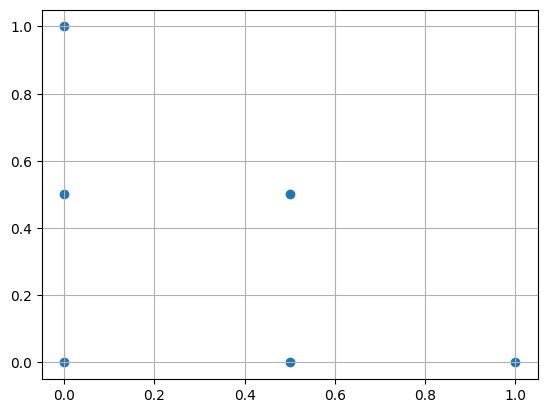

degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


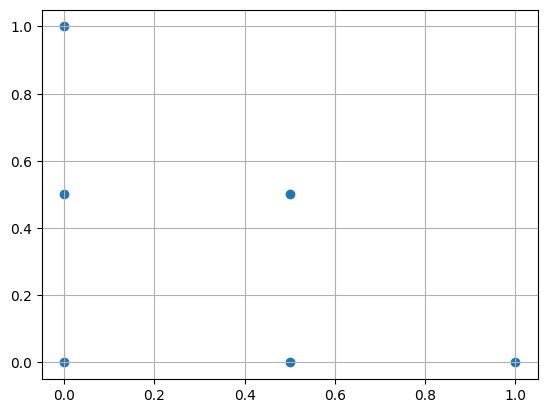

In [17]:
vp=VPINN(pb,params,B,model)

In [18]:
tf.reduce_mean(tf.square(model(vp.boundary_points) - vp.u_bound_exact))

<tf.Tensor: shape=(), dtype=float64, numpy=0.5035065348165174>

In [19]:
_,c,J,B_D,B_DD=vp.b.change_of_coordinates(vp.mesh['vertices'][vp.mesh['triangles'][0]])

t=np.array(vp.grad_test)[0]

print((B_D@t))
print()
xy_quad_element=(B_D@ vp.grad_test)


print(xy_quad_element)

[[-5.01943047 -3.38357491 -1.09997987  0.95955137 -3.05385001 -1.87606661
  -0.23192371  1.25089772 -0.48931642  0.09081072  0.90064717  1.63102336
   1.47626404  1.59831901  1.76870333  1.92236972]
 [ 5.01943047  3.38357491  1.09997987 -0.95955137  3.05385001  1.87606661
   0.23192371 -1.25089772  0.48931642 -0.09081072 -0.90064717 -1.63102336
  -1.47626404 -1.59831901 -1.76870333 -1.92236972]]

tf.Tensor(
[[[ -5.01943047  -3.38357491  -1.09997987   0.95955137  -3.05385001
    -1.87606661  -0.23192371   1.25089772  -0.48931642   0.09081072
     0.90064717   1.63102336   1.47626404   1.59831901   1.76870333
     1.92236972]
  [  5.01943047   3.38357491   1.09997987  -0.95955137   3.05385001
     1.87606661   0.23192371  -1.25089772   0.48931642  -0.09081072
    -0.90064717  -1.63102336  -1.47626404  -1.59831901  -1.76870333
    -1.92236972]]

 [[  0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.     

In [20]:
print(vp.xy_quad_total)

tf.Tensor(
[[[0.54700955 0.48572395]
  [0.59431582 0.43078925]
  [0.66035365 0.35410239]
  [0.71991193 0.28493997]
  [0.66985833 0.48572395]
  [0.68853508 0.43078925]
  [0.71460716 0.35410239]
  [0.73812107 0.28493997]
  [0.83014167 0.48572395]
  [0.81146492 0.43078925]
  [0.78539284 0.35410239]
  [0.76187893 0.28493997]
  [0.95299045 0.48572395]
  [0.90568418 0.43078925]
  [0.83964635 0.35410239]
  [0.78008807 0.28493997]]

 [[0.2479093  0.2806428 ]
  [0.30665822 0.33176328]
  [0.38866959 0.40312563]
  [0.46263409 0.46748598]
  [0.18648491 0.34206719]
  [0.25954859 0.37887292]
  [0.36154283 0.43025238]
  [0.45352951 0.47659055]
  [0.10634324 0.42220886]
  [0.19808367 0.44033784]
  [0.32614999 0.46564522]
  [0.44165059 0.48846948]
  [0.04491885 0.48363325]
  [0.15097404 0.48744747]
  [0.29902324 0.49277198]
  [0.43254601 0.49757405]]

 [[0.2479093  0.7806428 ]
  [0.30665822 0.83176328]
  [0.38866959 0.90312563]
  [0.46263409 0.96748598]
  [0.18648491 0.84206719]
  [0.25954859 0.8788729

In [21]:
n_triangles=vp.n_triangles
xy_quad_total =vp.xy_quad_total

print(n_triangles)


x_eval=tf.reshape(vp.xy_quad_total,(-1,2))
grad=vp.eval_grad_NN(x_eval)

print(grad)

grad=tf.reshape(grad,(n_triangles,-1,2))

print(tf.shape(grad))

16


tf.Tensor(
[[ 0.10200879 -0.12570733]
 [ 0.10462373 -0.13083542]
 [ 0.10765312 -0.1379318 ]
 [ 0.10969023 -0.14417571]
 [ 0.10137057 -0.13178045]
 [ 0.10380619 -0.13529356]
 [ 0.10690843 -0.14029395]
 [ 0.10935521 -0.14489101]
 [ 0.09815384 -0.1397432 ]
 [ 0.10128441 -0.14113807]
 [ 0.10543148 -0.14338834]
 [ 0.10885909 -0.14582611]
 [ 0.09442974 -0.14558632]
 [ 0.09850736 -0.14550288]
 [ 0.1039674  -0.14574255]
 [ 0.1084358  -0.14654318]
 [ 0.10093894 -0.12904911]
 [ 0.10261747 -0.12612869]
 [ 0.10323281 -0.12361836]
 [ 0.10213867 -0.12273079]
 [ 0.09584483 -0.12203599]
 [ 0.09895278 -0.12093342]
 [ 0.10135568 -0.1207496 ]
 [ 0.10158475 -0.12179902]
 [ 0.08867924 -0.11316022]
 [ 0.0938143  -0.11429035]
 [ 0.09877117 -0.11703707]
 [ 0.10084592 -0.12058512]
 [ 0.08291751 -0.10663587]
 [ 0.08965855 -0.10933583]
 [ 0.0966962  -0.11422197]
 [ 0.10026762 -0.11965638]
 [ 0.08209616 -0.09701588]
 [ 0.08113753 -0.09789626]
 [ 0.07879076 -0.09962945]
 [ 0.07589859 -0.10146349]
 [ 0.07715    -0.

In [22]:
grad_elem=tf.transpose(grad[0])
print(grad_elem)

print(grad_elem @vp.w_quad)

tf.Tensor(
[[ 0.10200879  0.10462373  0.10765312  0.10969023  0.10137057  0.10380619
   0.10690843  0.10935521  0.09815384  0.10128441  0.10543148  0.10885909
   0.09442974  0.09850736  0.1039674   0.1084358 ]
 [-0.12570733 -0.13083542 -0.1379318  -0.14417571 -0.13178045 -0.13529356
  -0.14029395 -0.14489101 -0.1397432  -0.14113807 -0.14338834 -0.14582611
  -0.14558632 -0.14550288 -0.14574255 -0.14654318]], shape=(2, 16), dtype=float64)
tf.Tensor(
[[ 0.10282396]
 [-0.13891988]], shape=(2, 1), dtype=float64)


In [23]:

w_quad = tf.concat([vp.w_quad.T, tf.ones_like(vp.w_quad.T)], axis=0)
print(w_quad)


tf.Tensor(
[[0.04713674 0.07077614 0.0451681  0.01084645 0.08837018 0.13268843
  0.08467945 0.02033452 0.08837018 0.13268843 0.08467945 0.02033452
  0.04713674 0.07077614 0.0451681  0.01084645]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]], shape=(2, 16), dtype=float64)


In [24]:
vp.grad_test

<tf.Tensor: shape=(6, 2, 16), dtype=float64, numpy=
array([[[-2.50971524, -1.69178745, -0.54998993,  0.47977568,
         -1.52692501, -0.93803331, -0.11596185,  0.62544886,
         -0.24465821,  0.04540536,  0.45032358,  0.81551168,
          0.73813202,  0.79915951,  0.88435166,  0.96118486],
        [-2.50971524, -1.69178745, -0.54998993,  0.47977568,
         -1.52692501, -0.93803331, -0.11596185,  0.62544886,
         -0.24465821,  0.04540536,  0.45032358,  0.81551168,
          0.73813202,  0.79915951,  0.88435166,  0.96118486]],

       [[-0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.   

In [25]:
vp.mesh['triangles']

array([[ 4, 12,  9],
       [ 8,  4,  5],
       [10,  7,  3],
       [ 3,  5, 10],
       [12,  4,  6],
       [ 4,  8,  6],
       [ 0,  6,  8],
       [11,  2,  7],
       [ 5,  0,  8],
       [ 9,  2, 11],
       [ 4,  7, 10],
       [ 5,  4, 10],
       [ 4,  9, 11],
       [ 7,  4, 11],
       [ 1,  9, 12],
       [ 6,  1, 12]], dtype=int32)

In [26]:
print(vp.mesh['triangles'][0][1])

12


tf.Tensor(0.6760486052503494, shape=(), dtype=float64)
Iteration: 0 loss: 0.6760486053 time: 0.2646667957305908
tf.Tensor(0.6702770174494213, shape=(), dtype=float64)
tf.Tensor(0.6684568895558356, shape=(), dtype=float64)
tf.Tensor(0.6677109234018164, shape=(), dtype=float64)
tf.Tensor(0.6676819751275851, shape=(), dtype=float64)
tf.Tensor(0.6679472416544524, shape=(), dtype=float64)
tf.Tensor(0.667995767158825, shape=(), dtype=float64)
tf.Tensor(0.6678680910382148, shape=(), dtype=float64)
tf.Tensor(0.6677714238783612, shape=(), dtype=float64)
tf.Tensor(0.6677254300698277, shape=(), dtype=float64)
tf.Tensor(0.6676491605843902, shape=(), dtype=float64)
tf.Tensor(0.6675253112426963, shape=(), dtype=float64)
tf.Tensor(0.6674046415865286, shape=(), dtype=float64)
tf.Tensor(0.6673297058169593, shape=(), dtype=float64)
tf.Tensor(0.6672818202346547, shape=(), dtype=float64)
tf.Tensor(0.667199923260621, shape=(), dtype=float64)
tf.Tensor(0.6670553878025005, shape=(), dtype=float64)
tf.Tensor(

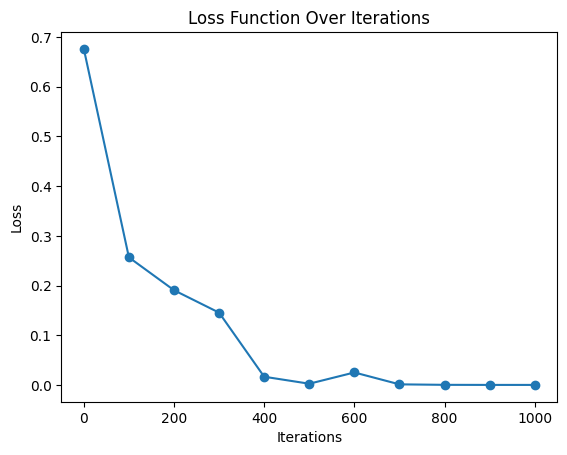

In [27]:

history=vp.train(1000)

iterations = range(0, len(history) * 100, 100)  # Assuming losses are provided every 100 iterations

plt.plot(iterations, history, marker='o')
plt.title('Loss Function Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()



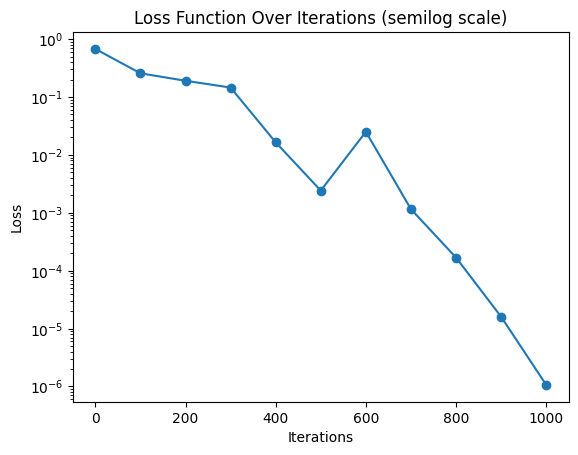

In [36]:
plt.semilogy(iterations, history, marker='o')
plt.title('Loss Function Over Iterations (semilog scale)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [28]:

indices = tf.constant([[[triangle[0],1]], [[triangle[1],1]], [[triangle[2],1]]])


In [29]:
print(vp.NN.trainable_variables)

[<tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float64, numpy=
array([[-1.28489752, -0.2638951 , -0.42274776, -0.80912451, -0.89786172,
        -0.52824913,  0.26612033, -0.14141708,  0.38235446,  0.27636457],
       [-0.11807826, -0.64044107,  0.20724214, -0.5325438 , -0.79829513,
        -0.03969495, -0.21049093, -0.22289309, -0.30539215,  1.33464356]])>, <tf.Variable 'dense/bias:0' shape=(10,) dtype=float64, numpy=
array([ 0.28975958,  0.27672256,  0.40350787,  0.26164453,  0.36330963,
       -0.27528728, -0.65983503,  0.28870407,  0.25220013,  0.19456832])>, <tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float64, numpy=
array([[ 0.91348098,  0.10722392,  0.01844883,  0.80919548, -0.16302617,
         0.70955737, -0.02592864, -0.28620338,  0.35703758, -1.11405985],
       [ 0.25563481,  0.76130265,  0.19128496,  0.29600792, -0.57397277,
        -0.02433926, -0.01284571,  0.30861452, -1.11864379,  0.39897861],
       [ 0.18843295,  0.06314449, -0.11973988,  0.24441555, -0.2

In [30]:
tensor = tf.constant([[1, 1,1, 1]])    # tf.rank(tensor) == 2
indices = [[0,0]]           # num_updates == 2, index_depth == 2
updates = [5]                    # num_updates == 2
print(tf.tensor_scatter_nd_update(tensor, indices, updates))

print(vp.F_total_edges)


tf.Tensor([[5 1 1 1]], shape=(1, 4), dtype=int32)
tf.Tensor(
[[-1.98576243e+00]
 [-1.98552141e+00]
 [-2.28600487e-07]
 [-2.75298903e+00]
 [-2.22044605e-16]
 [-4.47290951e+00]
 [ 2.75294757e+00]
 [ 0.00000000e+00]
 [ 4.47290951e+00]
 [ 0.00000000e+00]
 [ 4.46689186e+00]
 [-2.78867744e+00]
 [-1.98578880e+00]
 [-2.75298903e+00]
 [ 0.00000000e+00]
 [-4.46689186e+00]
 [ 1.98552539e+00]
 [ 0.00000000e+00]
 [ 1.98578880e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.98555322e+00]
 [ 2.78872579e+00]
 [ 2.75299062e+00]
 [ 1.98576107e+00]
 [ 0.00000000e+00]
 [-1.98555322e+00]
 [ 0.00000000e+00]], shape=(28, 1), dtype=float64)


In [31]:
vp.boundary_points

<tf.Tensor: shape=(320, 2), dtype=float64, numpy=
array([[0.    , 0.    ],
       [0.0125, 0.    ],
       [0.025 , 0.    ],
       [0.0375, 0.    ],
       [0.05  , 0.    ],
       [0.0625, 0.    ],
       [0.075 , 0.    ],
       [0.0875, 0.    ],
       [0.1   , 0.    ],
       [0.1125, 0.    ],
       [0.125 , 0.    ],
       [0.1375, 0.    ],
       [0.15  , 0.    ],
       [0.1625, 0.    ],
       [0.175 , 0.    ],
       [0.1875, 0.    ],
       [0.2   , 0.    ],
       [0.2125, 0.    ],
       [0.225 , 0.    ],
       [0.2375, 0.    ],
       [0.25  , 0.    ],
       [0.2625, 0.    ],
       [0.275 , 0.    ],
       [0.2875, 0.    ],
       [0.3   , 0.    ],
       [0.3125, 0.    ],
       [0.325 , 0.    ],
       [0.3375, 0.    ],
       [0.35  , 0.    ],
       [0.3625, 0.    ],
       [0.375 , 0.    ],
       [0.3875, 0.    ],
       [0.4   , 0.    ],
       [0.4125, 0.    ],
       [0.425 , 0.    ],
       [0.4375, 0.    ],
       [0.45  , 0.    ],
       [0.4625, 0.    ],


In [32]:
a=tf.constant([1.0 ,2.0])


print(a)



tf.Tensor([1. 2.], shape=(2,), dtype=float32)


In [33]:
b=tf.Variable([1.0 ,2.0])

print(b)

b[0].assign(6.0)

print(b)


<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 2.], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([6., 2.], dtype=float32)>


In [34]:
x=tf.constant(6.0)

def f(x):
    return x*x


with tf.GradientTape() as tape:
    tape.watch(x)
    res=f(x)
grad=tape.gradient(res,x)


print(res,grad,12)


tf.Tensor(36.0, shape=(), dtype=float32) tf.Tensor(12.0, shape=(), dtype=float32) 12


In [35]:
x=tf.Variable(3.0)
y=tf.Variable(1.0)

def f(x):
    return np.sin(x)



with tf.GradientTape(persistent=True) as tape:
    #y.assign_add(x)
    z=x+y
    res=f(z)        #(x+y)^2
    temp=np.array(res)

grad=tape.gradient(res,x)  
#grad_=tape.gradient(temp,x)


print(res,grad)
print(grad_)

AttributeError: 'numpy.float32' object has no attribute '_id'

In [ ]:
x=.constant(3.0)
def f(x):
    return x*x



with tf.GradientTape() as tape:
    #y.assign_add(x)
    tape.watch(x)
    res=f(x)


grad=tape.gradient(res,x)   


print(res,grad)

ValueError: Passed in object 3.0 of type 'ndarray', not tf.Tensor or tf.Variable or ExtensionType.

In [ ]:
x=tf.constant((1,2))

print(x)

x[0]=1

tf.Tensor([1 2], shape=(2,), dtype=int32)


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [ ]:
import tensorflow as tf

# Define the shape of the row vector
vector_length = 10

# Specify the indices where you want to place non-zero values
non_zero_indices = tf.constant([[2], [5], [8]], dtype=tf.int32)

# Specify the values to be placed at the specified indices
non_zero_values = tf.constant([[1.0], [2.0], [3.0]], dtype=tf.float32)

# Create the row vector with zeros and the specified values
row_vector = tf.scatter_nd(non_zero_indices, non_zero_values, shape=(vector_length,1))

# Print the result
print(row_vector.numpy())


print(row_vector[1][0])




[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [3.]
 [0.]]
tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
x=tf.Variable(tf.zeros((1,2),dtype=tf.float64))
print(x)

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float64, numpy=array([[0., 0.]])>
